## Cosine similarity performance analysis with filtered data and tolerance of 0.25

## Obtaining the data from the Mona File

## Getting the path for Mona file

Using the method load_from_msp, the information inside the Mona file is being obtained.

In [1]:
import os
import sys

ROOT = os.path.dirname(os.getcwd())
sys.path.insert(0, ROOT)

In [2]:
from custom_functions.spectra_functions import get_data_folder_path

# from_external=False to use the data folder within the project
path = get_data_folder_path(from_external=False)
spectrums_file = os.path.join(path, "MoNA-export-GC-MS.msp")

## Appliying filters to the spectra

Applied filters are:
* normalize_intensities(s)
* reduce_to_number_of_peaks(s, **n_required=10**, **ratio_desired=0.5**)
* select_by_mz(s, **mz_from=0**, **mz_to=1000**)
* require_minimum_number_of_peaks(s, **n_required=10**)

In [3]:
from matchms.filtering import normalize_intensities
from matchms.filtering import reduce_to_number_of_peaks
from matchms.filtering import select_by_mz
from matchms.filtering import require_minimum_number_of_peaks
from matchms.importing import load_from_msp

def apply_my_filters(s):
    s = normalize_intensities(s)
    s = reduce_to_number_of_peaks(s, n_required=10, ratio_desired=0.5)
    s = select_by_mz(s, mz_from=0, mz_to=1000)
    s = require_minimum_number_of_peaks(s, n_required=10)
    return s

spectrums = [apply_my_filters(s) for s in load_from_msp(spectrums_file)]

spectrums = [s for s in spectrums if s is not None]

## Grouping spectra by same and different molecules

Using the methods **separate_by_same_inchikey** and **separate_by_diff_inchikey**, the spectra is being separated in groups of groupes of spectra that are from the same and different molecule.

First group the spectra by the inchikey

In [4]:
def group_by_inchikey(spectrums):
    grouped_spectrum = []
    inchikeys = []
    for s in spectrums:
        inchikey = s.metadata.get('inchikey').split('-', 1)[0]
        if inchikey not in inchikeys:
            inchikeys.append(inchikey)
            grouped_spectrum.append([s]) 
        else:
            index = inchikeys.index(inchikey)
            grouped_spectrum[index].append(s)
    return grouped_spectrum

Then obtaining one thousand samples in pairs of 2 spectra that have the same molecule

In [5]:
import random

group_spectra_same_molecule = random.sample([k for k in group_by_inchikey(spectrums) if len(k) == 2], 1000)

Lastly obtaining one thousand samples in pairs of 2 spectra that have different molecules.
To achieve that the list with pairs of 2 spectra with the same molecules are used to replace the second pair with another that has a different molecule

In [6]:
group_spectra_diff_molecule = [[g[0]] for g in group_spectra_same_molecule]

for k, e in enumerate(group_spectra_diff_molecule):
    diff_mol = random.sample(spectrums, 1)
    while e[0].metadata['inchikey'].split('-', 1)[0] == diff_mol[0].metadata['inchikey'].split('-', 1)[0]:
        diff_mol = random.sample(spectrums, 1)
    group_spectra_diff_molecule[k].append(diff_mol[0])

# Computing the Cosine Similarity

## Defining the method to compute the similarity scores

This method will have a **default tolerance of 0.1**, it will return an numpy array with the reference spectra, query spectra, the score and matched peaks.

In [8]:
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
import numpy as np

def calculate_similarity_scores(group_spectra, tolerance=0.1, show_data = False):
    scores_hist = []
    for k, spectrums in enumerate(group_spectra):
        
        scores = calculate_scores(references=spectrums,
                                queries=spectrums,
                                similarity_function=CosineGreedy(tolerance))
        
        for k, score in enumerate(scores):
            if k == 1:
                (reference, query, score, n_matching) = score
                
                scores_hist.append({'reference':reference, 'query':query, 'score':score, 'n_matching':n_matching})
                
                if show_data:
                    print(f"Reference scan name: {reference.metadata['name']} - Query scan name: {query.metadata['name']}")
                    print(f"Reference InChiKey: {reference.metadata['inchikey']} - Query InChiKey: {query.metadata['inchikey']}")
                    print(f"Score: {score:.4f}")
                    print(f"Number of matching peaks: {n_matching}")
                    print("----------------------------")

    return np.array(scores_hist)

## Computing the similarities of spectra with same and diff molecule

In this case the **tolerance will be 0.5**

In [9]:
similarity_same_molecule = calculate_similarity_scores(group_spectra_same_molecule, 0.5)
similarity_diff_molecule = calculate_similarity_scores(group_spectra_diff_molecule, 0.5)

# Plotting histograms of the obtained scores

The following histrograms show those of the same and different molecules.

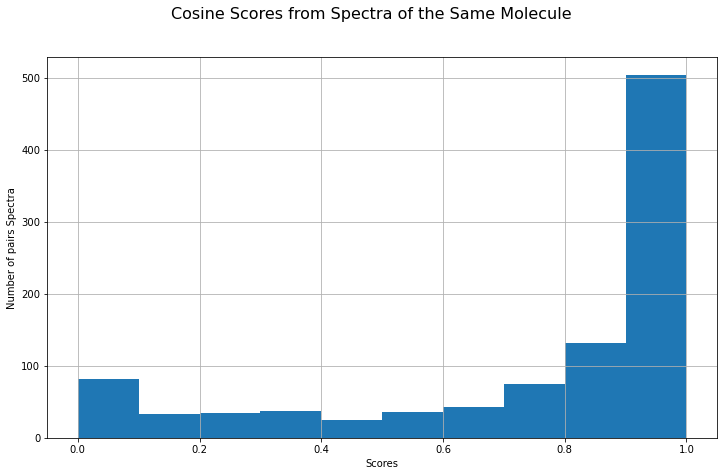

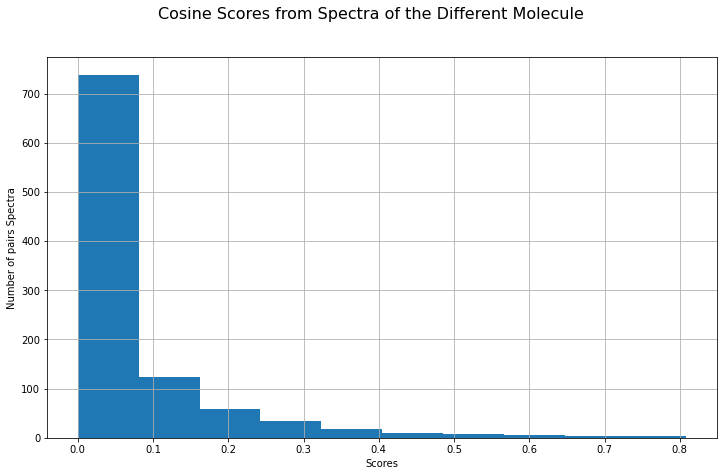

In [10]:
import matplotlib.pyplot as plt

def print_histogram(data, title=None):
    plt.figure(figsize=(12,7))
    plt.grid(True)
    hist = plt.hist(data)
    if title is not None:
        plt.suptitle(title, fontsize=16)
    plt.xlabel("Scores")
    plt.ylabel("Number of pairs Spectra")
    plt.show()

scores_same_molecule = [g['score'] for g in similarity_same_molecule]
scores_diff_molecule = [g['score'] for g in similarity_diff_molecule]

print_histogram(scores_same_molecule, "Cosine Scores from Spectra of the Same Molecule")
print_histogram(scores_diff_molecule, "Cosine Scores from Spectra of the Different Molecule")

# Filtering Spectra by cosine score less than 0.1

As observed in the histogram, when spectra of different molecules are compared the cosine similarity with a score lower than 0.1 is very high, however, when spectra of the same molecules are compared there is a significant number of spectra which are in this range (0.1), although the majority are higher than 0.8.

After filtering the spectra, 2 random samples are selected and ploted as a mirror plot to observe the behaviour.

## Sample 1 - Spectra with same molecule with cosine score less than 0.1

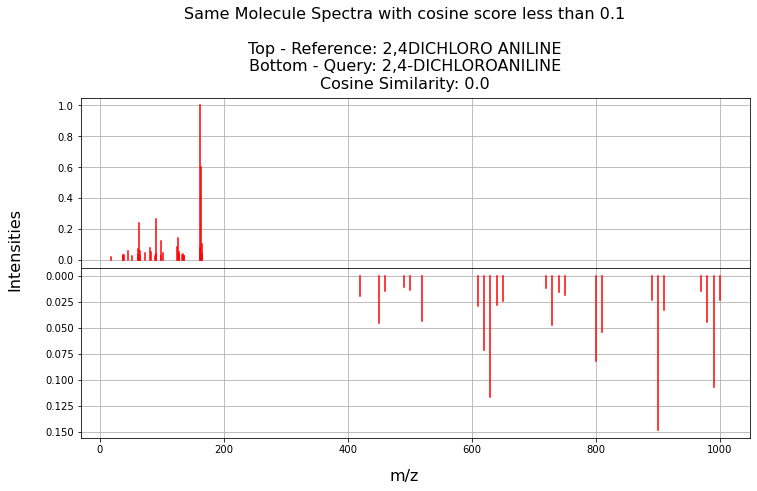

In [11]:
scores_same_molecule_low_cosine = [g for g in similarity_same_molecule if g['score'] < 0.1]

def print_mirror_plot(spectrum1, spectrum2, similarity, title=None, roundMz=False):
    fig, [ax1, ax2] = plt.subplots(2,1, sharex=True, figsize=(12,7))
    subtitle = 'Top - Reference: ' + spectrum1.metadata['name'] + '\n' + 'Bottom - Query: ' + spectrum2.metadata['name'] + '\n' + 'Cosine Similarity: ' + str(similarity) + '\n'

    if title is not None:
        subtitle = title + '\n\n' + subtitle
        fig.subplots_adjust(top=0.8)
        
    fig.suptitle(subtitle, fontsize=16)
    fig.text(0.5, 0.04, 'm/z', ha='center', fontsize=16)
    fig.text(0.04, 0.5, 'Intensities', va='center', rotation='vertical', fontsize=16)

    plt.subplots_adjust(hspace=0.0)
    ax1.grid(True)
    for mz,intensity in zip(spectrum1.peaks.mz, spectrum1.peaks.intensities):
        if roundMz:
            ax1.plot([round(mz),round(mz)],[0,intensity],'r')
        else:
            ax1.plot([mz,mz],[0,intensity],'r')
            
    ax2.grid(True)
    for mz,intensity in zip(spectrum2.peaks.mz, spectrum2.peaks.intensities):
        if roundMz:
            ax2.plot([round(mz),round(mz)],[0,intensity],'r')
        else:
            ax2.plot([mz,mz],[0,intensity],'r')
    ax2.set_ylim(ax2.get_ylim()[::-1])
    plt.show()

sample = random.sample(scores_same_molecule_low_cosine, 1)
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score less than 0.1')

## Sample 2 - Spectra with same molecule with cosine score less than 0.1

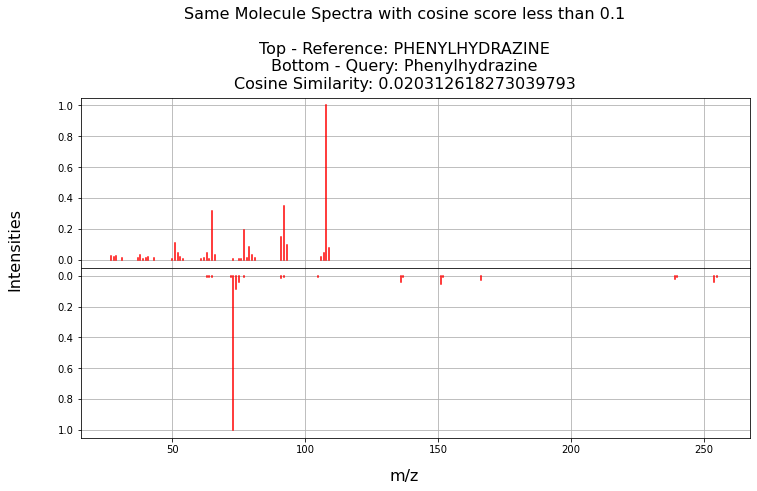

In [12]:
sample = random.sample(scores_same_molecule_low_cosine, 1)
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score less than 0.1')

# Filtering Spectra by cosine score higher than 0.9

Spectra of the same molecule now will be filtered by ones with a cosine score higher than 0.9.

In [13]:
scores = [g for g in similarity_same_molecule if g['score'] > 0.9]

## Sample 1 - Spectra with same molecule with cosine score higher than 0.9, without rounding cosine scores

### Plotting Sample 1 without rounding cosine scores

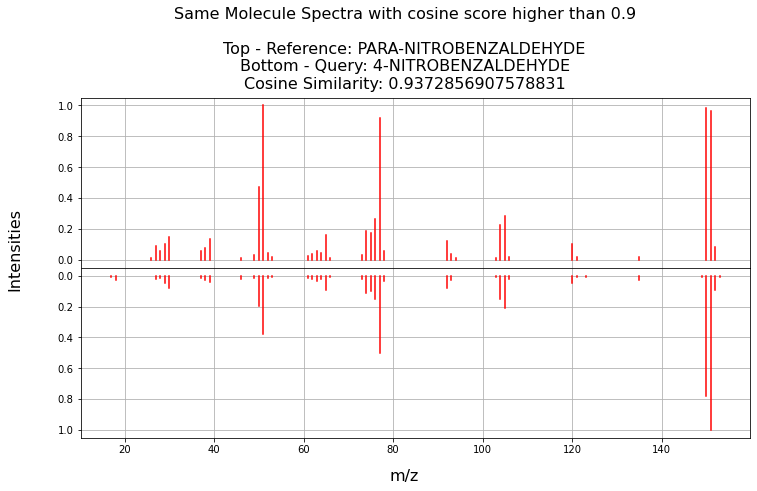

In [14]:
sample = random.sample(scores, 1)
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score higher than 0.9')

### Plotting Sample 2 rounding cosine scores

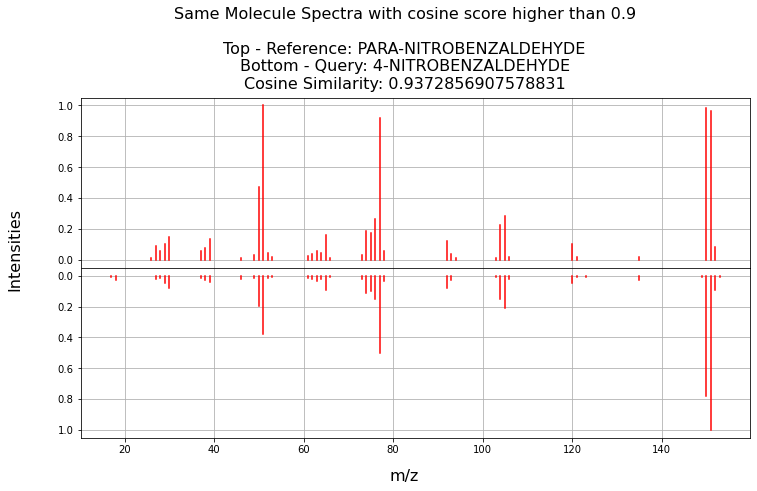

In [15]:
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score higher than 0.9', True)

## Sample 2 - Spectra with same molecule with cosine score higher than 0.9

### Plotting Sample 2 without rounding cosine scores

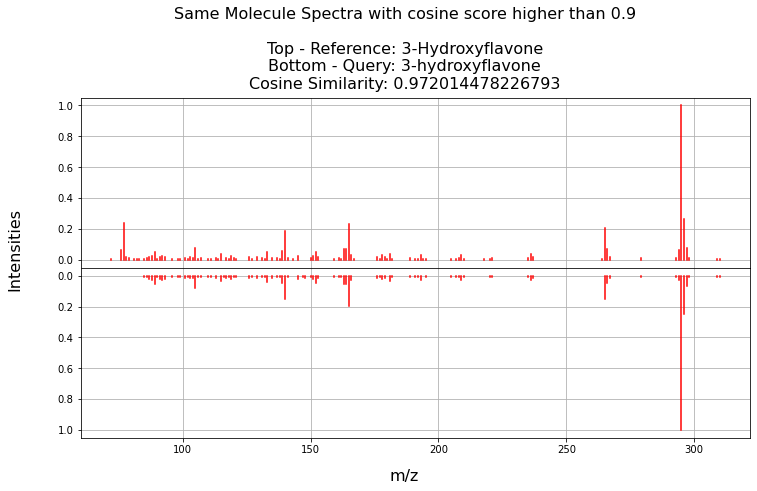

In [16]:
sample = random.sample(scores, 1)
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score higher than 0.9')

### Plotting Sample 2 rounding cosine scores

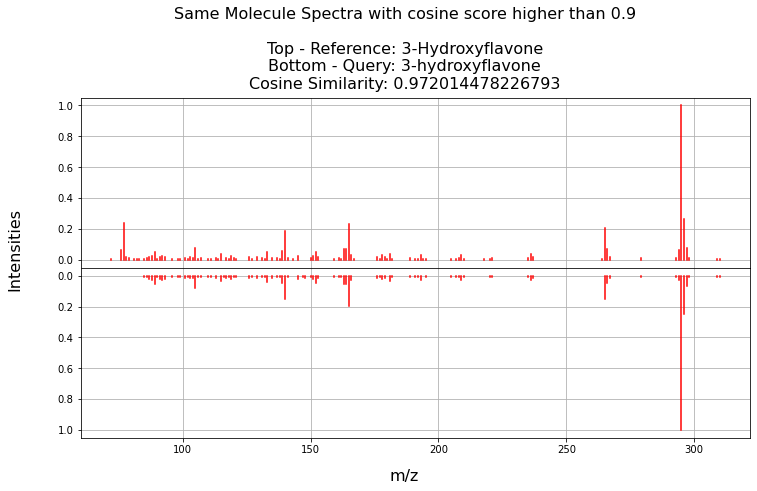

In [17]:
print_mirror_plot(sample[0]['reference'], sample[0]['query'], sample[0]['score'], 'Same Molecule Spectra with cosine score higher than 0.9', True)